## About Data


## Code


### Import libraries


In [95]:
import os
import random
import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt
import scipy.signal as signal


In [2]:
#@title Assign Numbers to Classes
classes = {
    'normal': 0, # Normal Heartbeat Sound
    'murmur': 1, # Murmur Heartbeat Sound
    'extrahs': 2, # Extra Heart Sound
    'extrastole': 3, # Extrasystole Heartbeat Sound
    'artifact': 4 # Artifact sound
}

In [3]:
#@title Folder Paths Dataset A
folder_paths_a = {
    'normal': './data/train/dataset_a/Atraining_normal',
    'murmur': './data/train/dataset_a/Atraining_murmur',
    'extrahs': './data/train/dataset_a/Atraining_extrahs',
    'artifact': './data/train/dataset_a/Atraining_artifact'
}

In [4]:
#@title Folder Paths Dataset B
folder_paths_b = {
    'normal': './data/train/dataset_b/Btraining_normal',
    'murmur': './data/train/dataset_b/Btraining_murmur',
    'extrastole': './data/train/dataset_b/Btraining_extrastole'
}

### Functions


In [5]:
def load_data(folder_path, cl):
    x = []
    y = []
    samples_rate = []

    file_names = os.listdir(folder_path)
    
    for file_name in file_names:
        try:
            file_path = os.path.join(folder_path, file_name)
        except:
            print(f"Error loading data of '{folder_path}'")
        else:
            audio, sr = librosa.load(file_path, sr=None)
            x.append(audio)
            label = classes.get(cl)
            y.append(label)
            samples_rate.append(sr)
            
    return x, y, samples_rate

In [6]:
def get_spectrum(audio, sample_rate):
    frequencies = np.fft.fftfreq(len(audio), d=1/sample_rate)
    fft_values = np.fft.fft(audio)

    # Absolute values
    magnitudes = np.abs(fft_values)

    half_freq = frequencies[:len(frequencies)//2]
    half_magn = magnitudes[:len(magnitudes)//2]

    # Find dominant frequency index
    dominant_index = np.argmax(half_magn)

    # Get dominant frequency
    dominant_frequency = frequencies[dominant_index]
    
    return half_freq, half_magn, dominant_frequency

In [152]:
# This function adjusts the duration of the audio segments to the desired time as well as setting a new sample rate for each one so that they all have the same one.
def fix_audio_length(audio_data, orig_sr, time_duration, target_sr=44100):
    data_fix = []
    new_length = int(target_sr*time_duration)

    # change the sample rate to the desired one
    for audio, sr in zip(audio_data, orig_sr):
        if target_sr != sr:
            resample_audio = librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)
            data_fix.append(resample_audio)
        else:
            data_fix.append(audio)
    
    # fix audio length
    for idx, audio in enumerate(data_fix):
        dur = librosa.get_duration(y=audio, sr=target_sr) # duraation

        if dur != time_duration:
            fixed_element = audio
            
            if dur < time_duration:
                fixed_element = np.tile(audio, int(np.ceil(new_length/len(audio)))) # Repeat the audio until completing the time or more
                
            fixed_element = fixed_element[:new_length] # Take the number of samples that complete the desired time
            data_fix[idx] = fixed_element
            
    return data_fix

In [ ]:
def FIR_filter(audio, sample_rate, cutoff_freq, num_taps):
    # Diseñar el filtro FIR
    fir_coeff = signal.firwin(numtaps=num_taps, cutoff=cutoff_freq, fs=sample_rate)

    # Aplicar el filtro a la señal de audio
    filtered_audio = signal.lfilter(fir_coeff, [1.0], audio)
    
    return filtered_audio

### Load Data


In [8]:
#@title Load set A and set B
# Dataset A
normal_a_data, normal_a_labels, normal_a_sr = load_data(folder_paths_a.get('normal'), classes.get('normal'))
murmur_a_data, murmur_a_labels, murmur_a_sr = load_data(folder_paths_a.get('murmur'), classes.get('murmur'))
extrahs_data, extrahs_labels, extrahs_sr = load_data(folder_paths_a.get('extrahs'), classes.get('extrahs'))
artifact_data, artifact_labels, artifact_sr = load_data(folder_paths_a.get('artifact'), classes.get('artifact'))
# Dataset B
normal_b_data, normal_b_labels, normal_b_sr = load_data(folder_paths_b.get('normal'), classes.get('normal'))
murmur_b_data, murmur_b_labels, murmur_b_sr = load_data(folder_paths_b.get('murmur'), classes.get('murmur'))
extrastole_data, extrastole_labels, extrastole_sr = load_data(folder_paths_b.get('extrastole'), classes.get('extrastole'))

# Num data per class set A
num_normal_a = len(normal_a_data)
num_murmur_a = len(murmur_a_data)
num_extrahs = len(extrahs_data)
num_artifact = len(artifact_data)
# Num data per class set B
num_normal_b = len(normal_b_data)
num_murmur_b = len(murmur_b_data)
num_extrastole = len(extrastole_data)

print('DATASET A')
print(f'Normal class: {num_normal_a} - Average sample rates: {np.mean(normal_a_sr)}')
print(f'Murmur class: {num_murmur_a} - Average sample rates: {np.mean(murmur_a_sr)}')
print(f'Extrahs class: {num_extrahs} - Average sample rates: {np.mean(extrahs_sr)}')
print(f'Artifact class: {num_artifact} - Average sample rates: {np.mean(artifact_sr)}')
print('\n')
print('DATASET B')
print(f'Normal class: {num_normal_b} - Average sample rates: {np.mean(normal_b_sr)}')
print(f'Murmur class: {num_murmur_b} - Average sample rates: {np.mean(murmur_b_sr)}')
print(f'Extrastole class: {num_extrastole} - Average sample rates: {np.mean(extrastole_sr)}')

DATASET A
Normal class: 31 - Average sample rates: 44100.0
Murmur class: 34 - Average sample rates: 44100.0
Extrahs class: 19 - Average sample rates: 44100.0
Artifact class: 40 - Average sample rates: 44100.0


DATASET B
Normal class: 200 - Average sample rates: 4000.0
Murmur class: 66 - Average sample rates: 4000.0
Extrastole class: 46 - Average sample rates: 4000.0


### Data Visualization


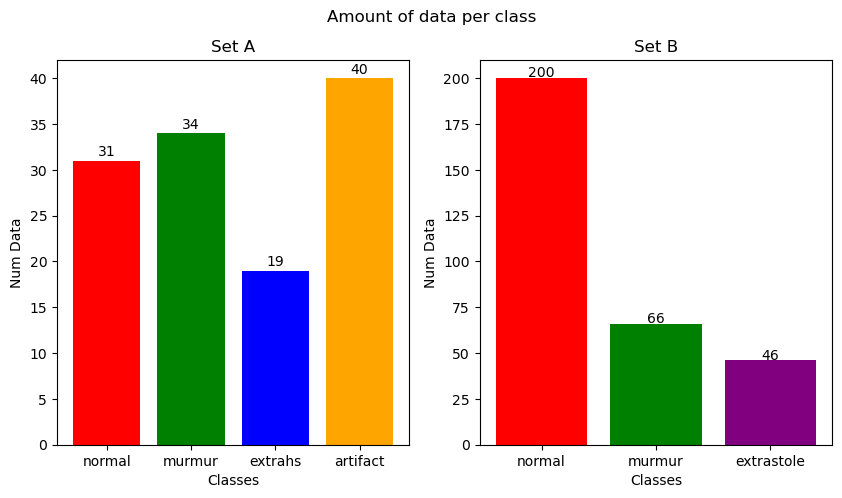

In [9]:
#@title Data distribution of each dataset
fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Amount of data per class')
# Bar Graph Dataset A
axs[0].bar(['normal', 'murmur', 'extrahs', 'artifact'], [num_normal_a, num_murmur_a, num_extrahs, num_artifact], color=['red', 'green', 'blue', 'orange']
)
for i, v in enumerate([num_normal_a, num_murmur_a, num_extrahs, num_artifact]):
    axs[0].text(i, v + 0.5, str(v), color='black', ha='center')
# Set title subplot A
axs[0].set_title('Set A')
# Set labels subplot A
axs[0].set(xlabel='Classes', ylabel='Num Data')
# Bar Graph Dataset B
axs[1].bar(['normal', 'murmur', 'extrastole'], [num_normal_b, num_murmur_b, num_extrastole], color=['red', 'green', 'purple']
)
for i, v in enumerate([num_normal_b, num_murmur_b, num_extrastole]):
    axs[1].text(i, v + 0.5, str(v), color='black', ha='center')

axs[1].set_title('Set B')
axs[1].set(xlabel='Classes', ylabel='Num Data')
plt.show()

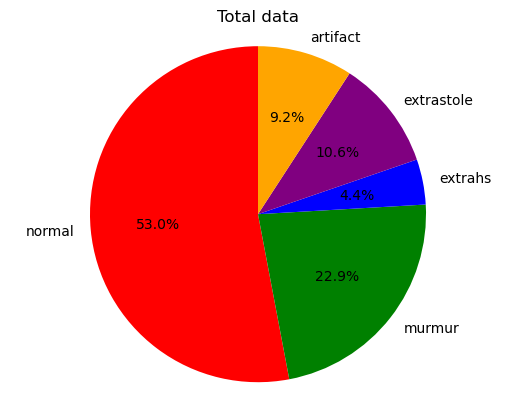

In [10]:
#@title Total Data
num_normal = num_normal_a + num_normal_b
num_murmur = num_murmur_a + num_murmur_b

num_classes = [num_normal, num_murmur, num_extrahs, num_extrastole, num_artifact]
tags = ['normal', 'murmur', 'extrahs', 'extrastole', 'artifact']

# Pie diagram
plt.pie(num_classes, labels=tags, autopct='%1.1f%%', startangle=90, colors=['red', 'green', 'blue', 'purple', 'orange'])
plt.axis('equal')
plt.title('Total data')
plt.show()

#### Dataset A


##### Normal Sound (normal)


In [168]:
#@title Normal Heartbeat Sound
idx = random.randint(0, len(normal_a_data)-1)
rnd_normal_a = normal_a_data[20]
rnd_normal_a_sr = normal_a_sr[20]
# play audio
Audio(rnd_normal_a, rate=rnd_normal_a_sr)

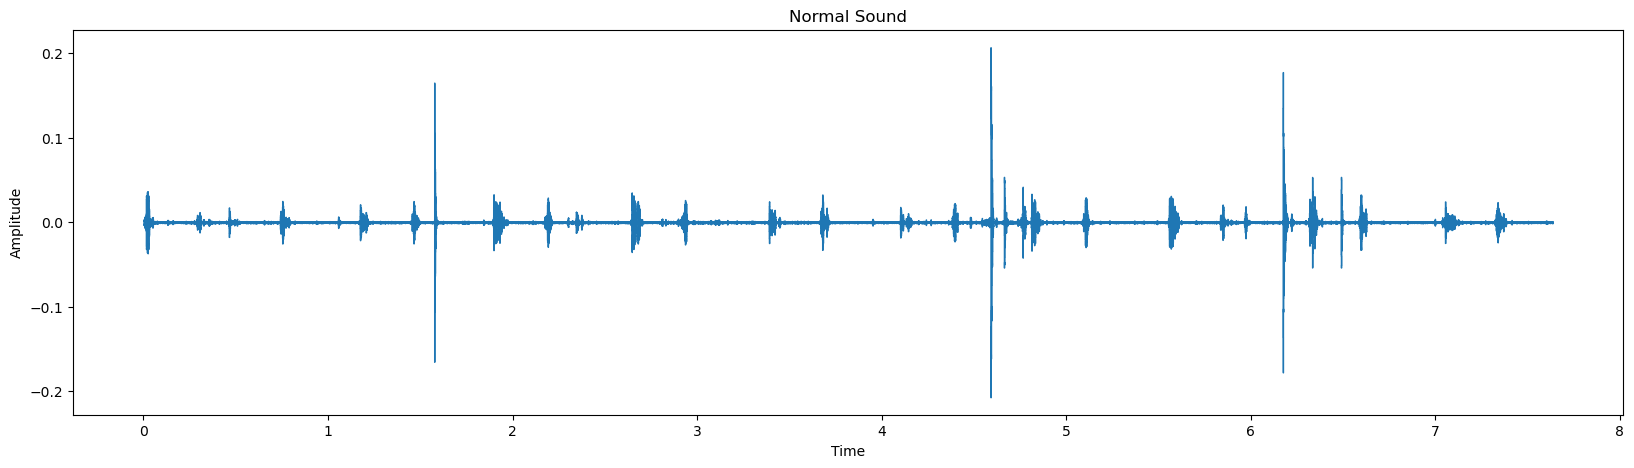

In [78]:
#@title Normal Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_normal_a, sr=rnd_normal_a_sr)
plt.title("Normal Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

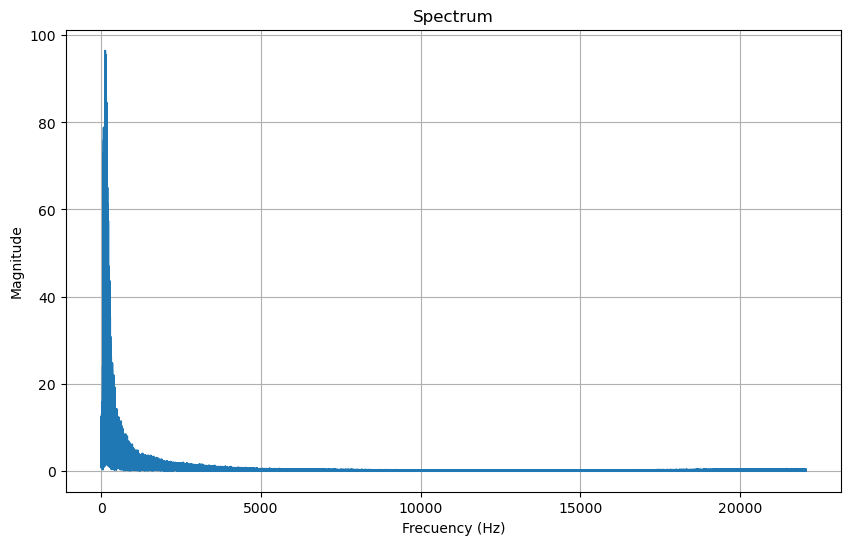

Dominant Frecuency: 125.03451285659574 Hz


In [115]:
#@title Normal Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_normal_a, rnd_normal_a_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

In [122]:
cutoff_freq = 195  # Frecuencia de corte en Hz
num_taps = 101  # Número de coeficientes del filtro (ajustable según necesidad)

# Diseñar el filtro FIR
fir_coeff = signal.firwin(numtaps=num_taps, cutoff=cutoff_freq, fs=rnd_normal_a_sr)

# Aplicar el filtro a la señal de audio
filtered_normal = signal.lfilter(fir_coeff, [1.0], rnd_normal_a)

In [123]:
Audio(filtered_normal, rate=rnd_normal_a_sr)

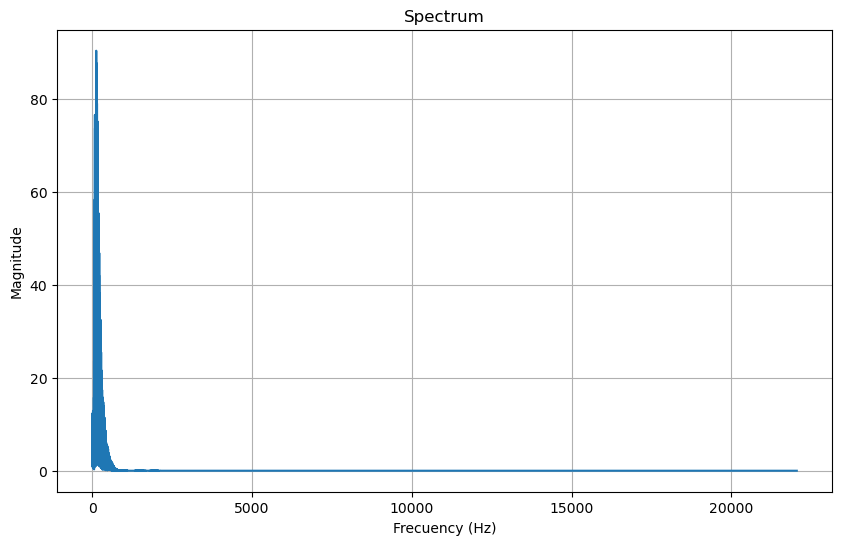

Dominant Frecuency: 125.03451285659574 Hz


In [119]:
#@title Normal Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(filtered_normal, rnd_normal_a_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Murmur Sound (murmur)


In [153]:
#@title Murmur Heartbeat Sound
idx = random.randint(0, len(murmur_a_data)-1)
rnd_murmur_a = murmur_a_data[idx]
rnd_murmur_a_sr = murmur_a_sr[idx]
# play audio
Audio(rnd_murmur_a, rate=rnd_murmur_a_sr)

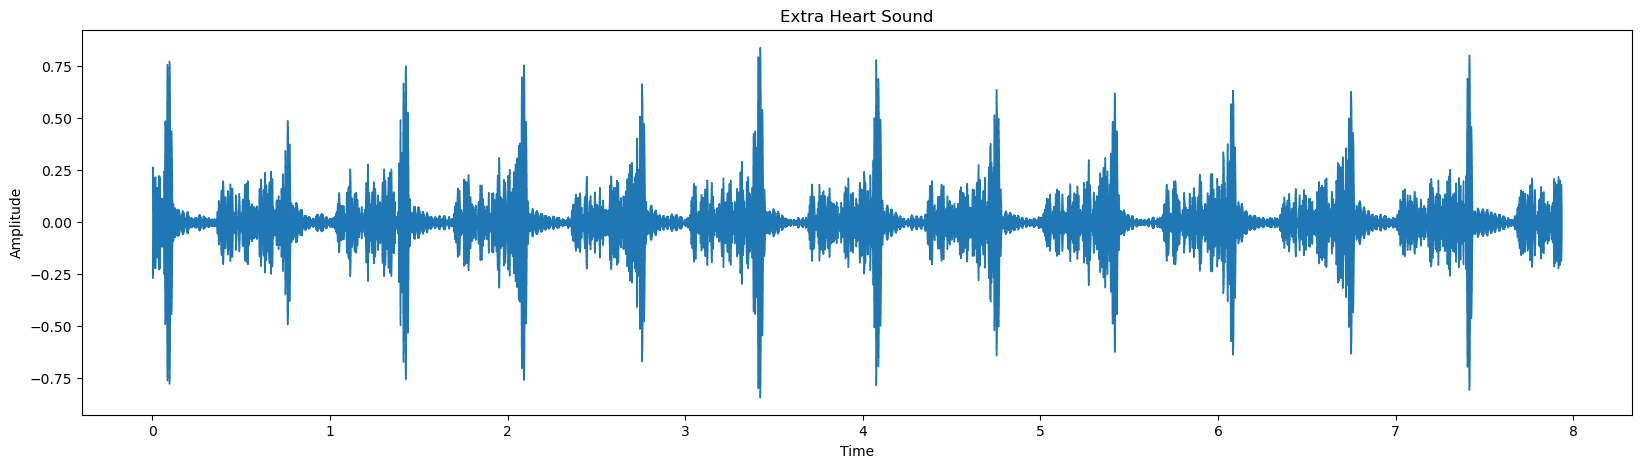

In [131]:
#@title Murmur Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_murmur_a, sr=rnd_murmur_a_sr)
plt.title("Extra Heart Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

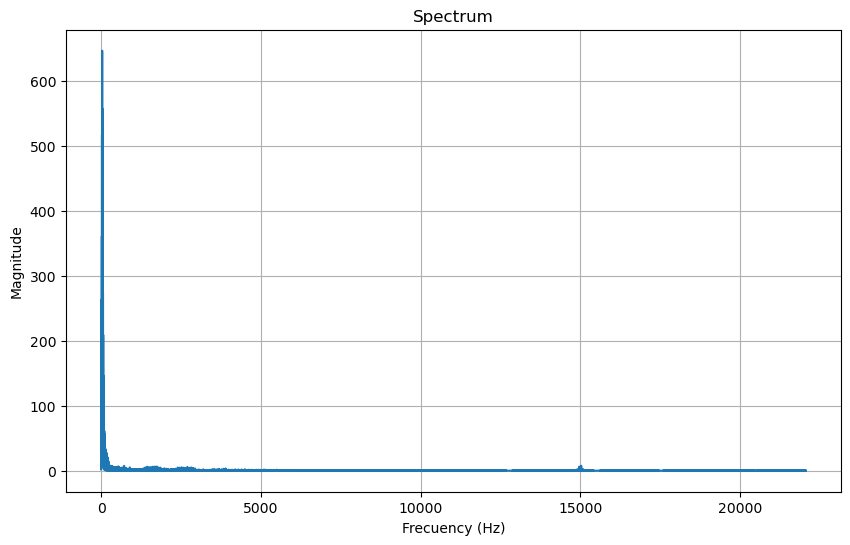

Dominant Frecuency: 33.092981645639085 Hz


In [154]:
#@title Murmur Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_murmur_a, rnd_murmur_a_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Extra Heart Sound (extrahs)


In [155]:
#@title Extra Heart Sound
idx = random.randint(0, len(extrahs_data)-1)
rnd_extrahs = extrahs_data[idx]
rnd_extrahs_sr = extrahs_sr[idx]
# play audio
Audio(rnd_extrahs, rate=rnd_extrahs_sr)

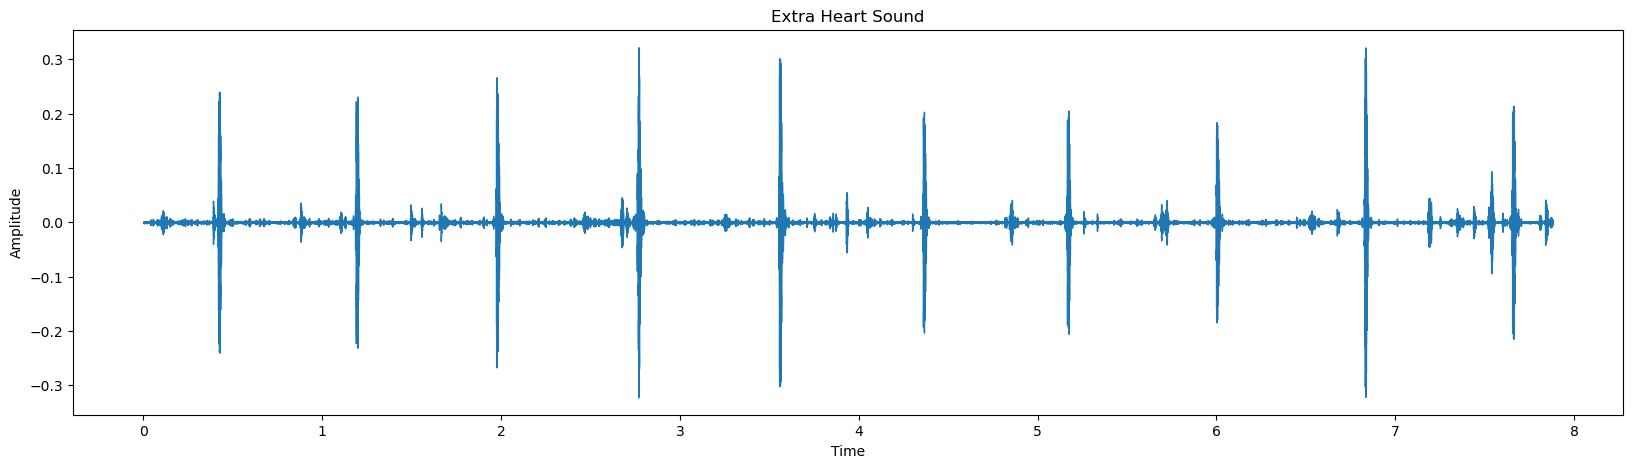

In [156]:
#@title Extra Heart Sound Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_extrahs, sr=rnd_extrahs_sr)
plt.title("Extra Heart Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

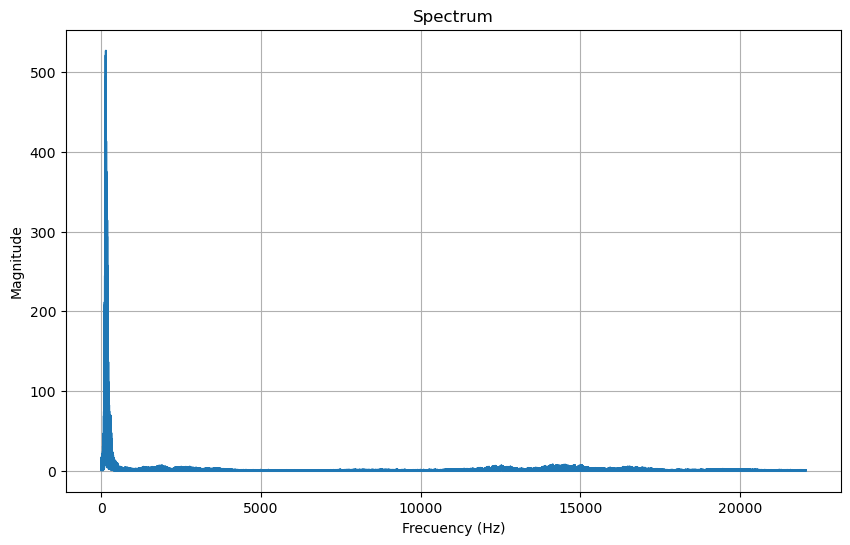

Dominant Frecuency: 149.10738436570193 Hz


In [157]:
#@title Extra Heart Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_extrahs, rnd_extrahs_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Artifact Sound (artifact)


In [158]:
#@title Artifact sound
idx = random.randint(0, len(artifact_data)-1)
rnd_artifact = artifact_data[idx]
rnd_artifact_sr = artifact_sr[idx]
# play audio
Audio(rnd_artifact, rate=rnd_artifact_sr)

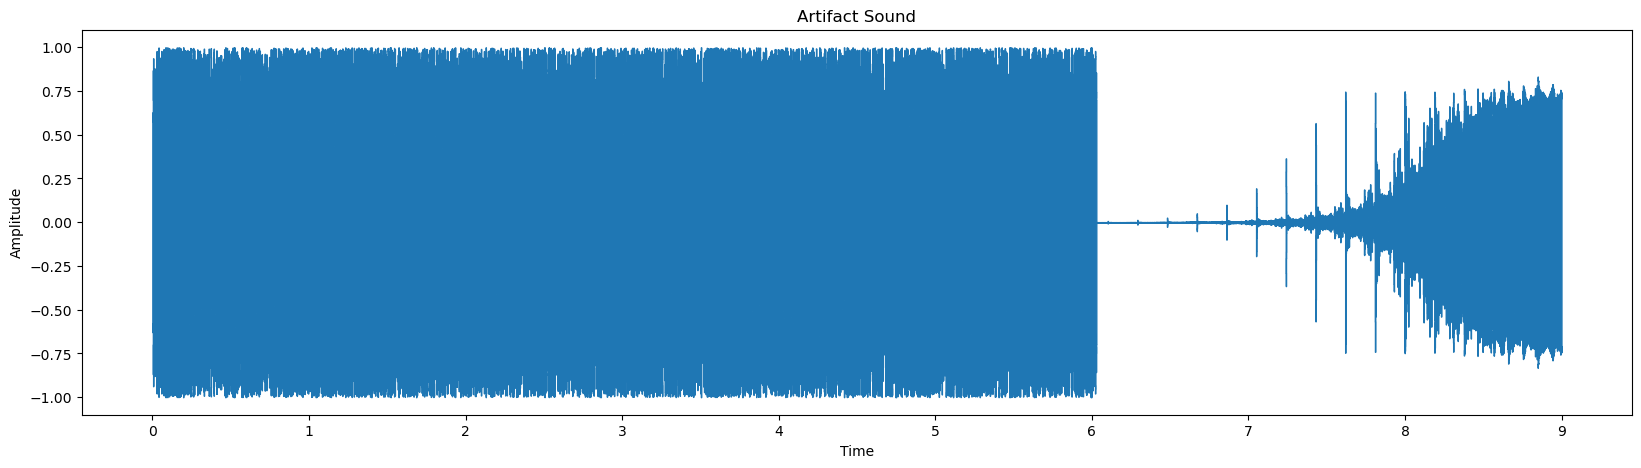

In [159]:
#@title Artifact Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_artifact, sr=rnd_artifact_sr)
plt.title("Artifact Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

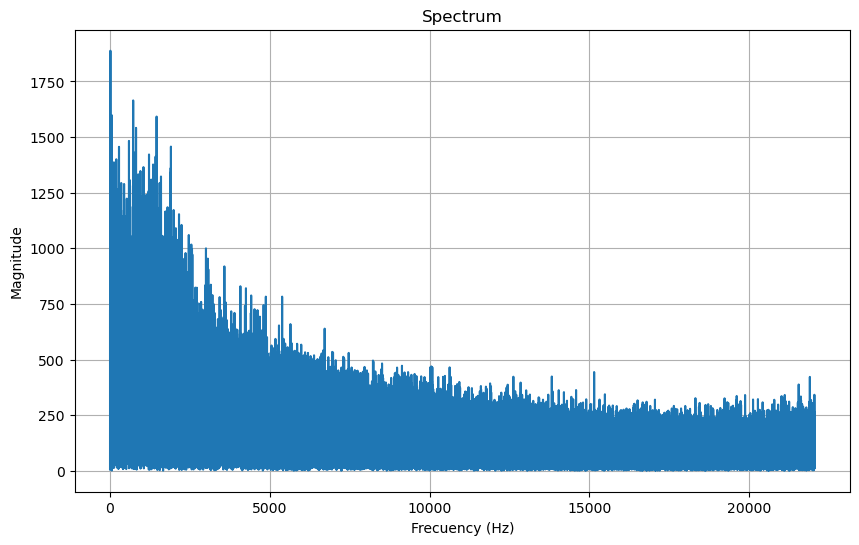

Dominant Frecuency: 12.888888888888888 Hz


In [160]:
#@title Artifact Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_artifact, rnd_artifact_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

#### Dataset B


##### Normal Sound (normal)


In [161]:
#@title Normal Heartbeat
idx = random.randint(0, len(normal_b_data)-1)
rnd_normal_b = normal_b_data[idx]
rnd_normal_b_sr = normal_b_sr[idx]
# play audio
Audio(rnd_normal_b, rate=rnd_normal_b_sr)

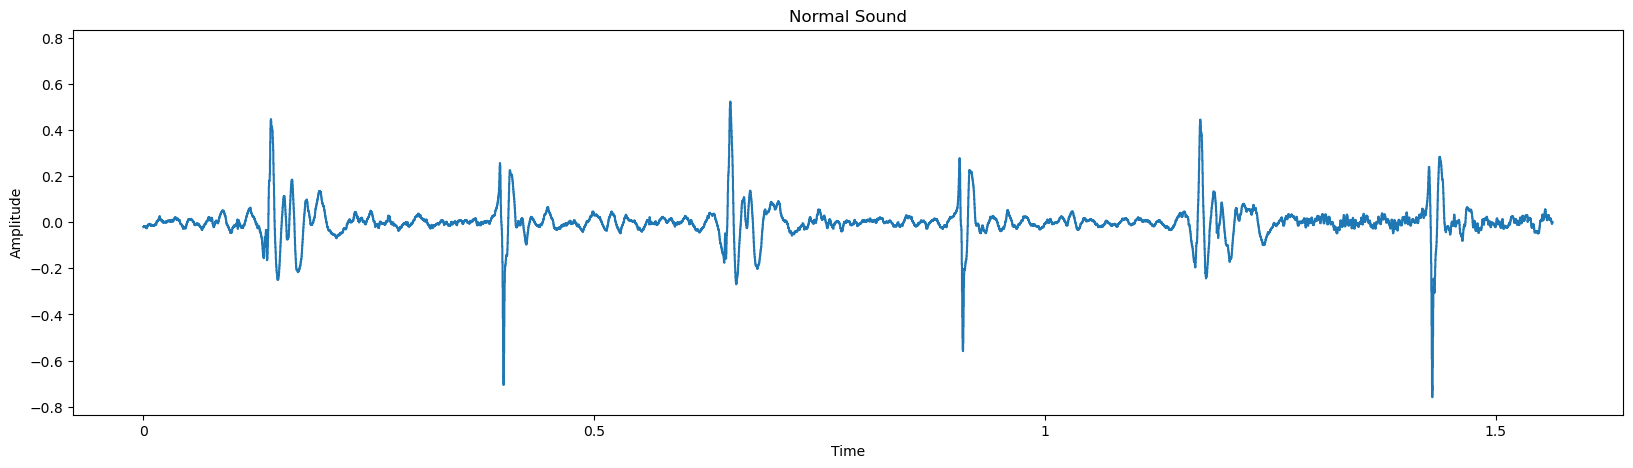

In [162]:
#@title Normal Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_normal_b, sr=rnd_normal_b_sr)
plt.title("Normal Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

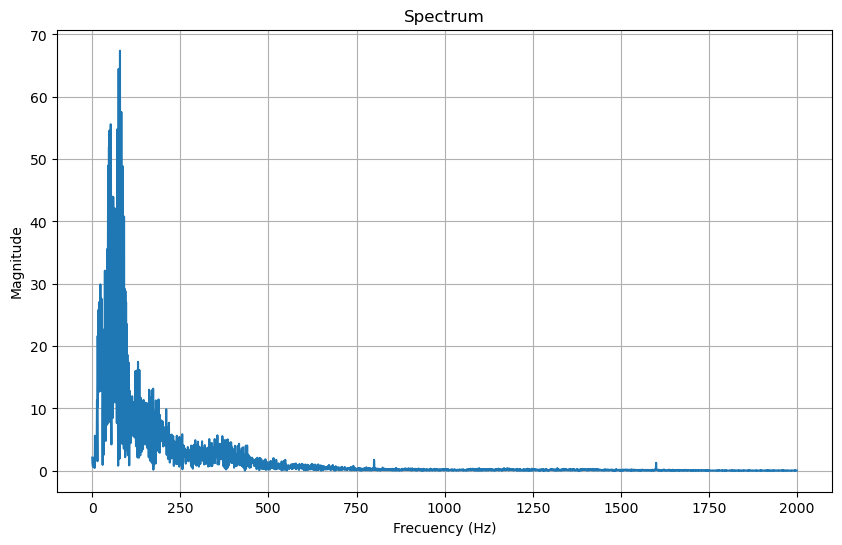

Dominant Frecuency: 78.69481765834932 Hz


In [163]:
#@title Normal Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_normal_b, rnd_normal_b_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Murmur Sound (murmur)


In [164]:
#@title Murmur Heartbeat Sound
idx = random.randint(0, len(murmur_b_data)-1)
rnd_murmur_b = murmur_b_data[idx]
rnd_murmur_b_sr = murmur_b_sr[idx]
# play audio
Audio(rnd_murmur_b, rate=rnd_murmur_b_sr)

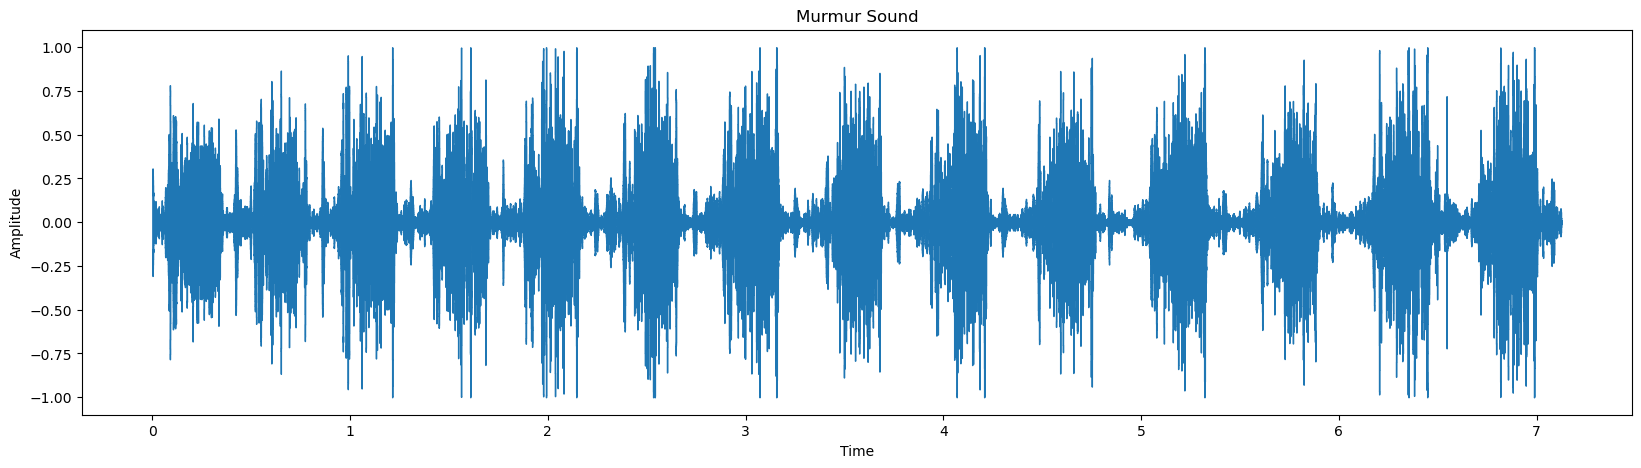

In [165]:
#@title Murmur Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_murmur_b, sr=rnd_murmur_b_sr)
plt.title("Murmur Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

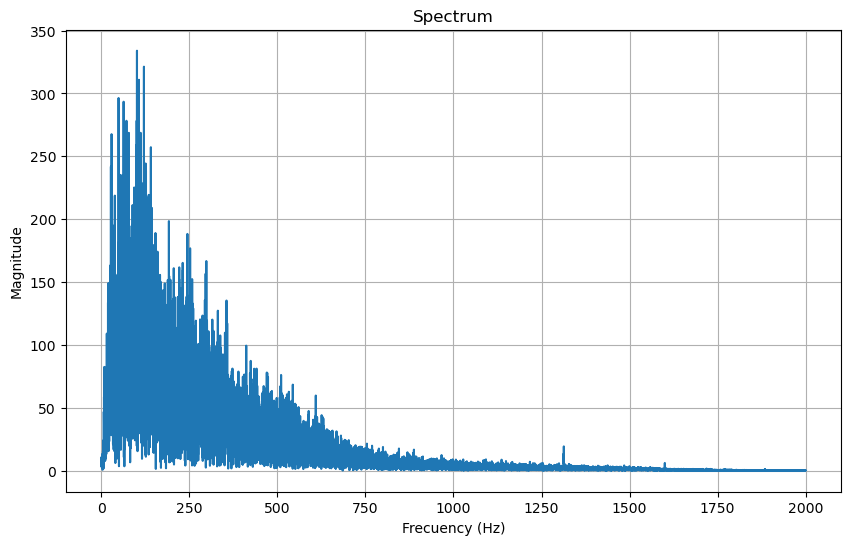

Dominant Frecuency: 101.73653744957025 Hz


In [166]:
#@title Murmur Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_murmur_b, rnd_murmur_b_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

##### Extrasystole Sound (extrastole)


In [167]:
#@title Extrasistole Heartbeat Sound
idx = random.randint(0, len(extrastole_data)-1)
rnd_extrastole = extrastole_data[idx]
rnd_extrastole_sr = extrastole_sr[idx]
# play audio
Audio(rnd_extrastole, rate=rnd_extrastole_sr)

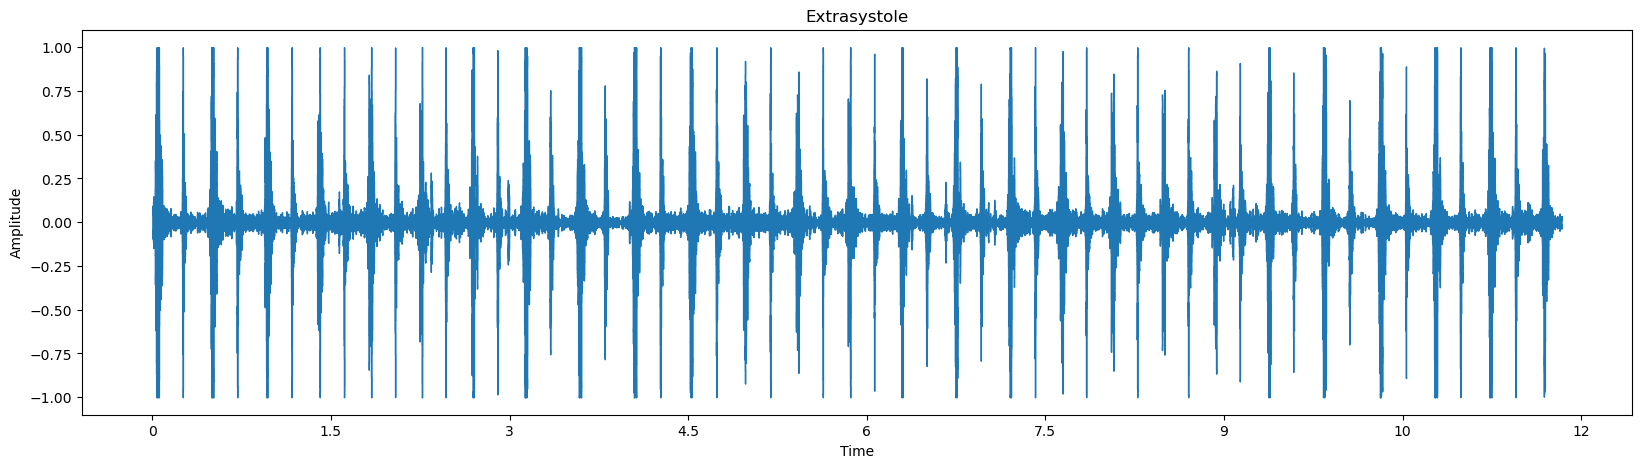

In [168]:
#@title Extrasystole Waveform
plt.figure(figsize=(20,5))
librosa.display.waveshow(rnd_extrastole, sr=rnd_extrastole_sr)
plt.title("Extrasystole")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

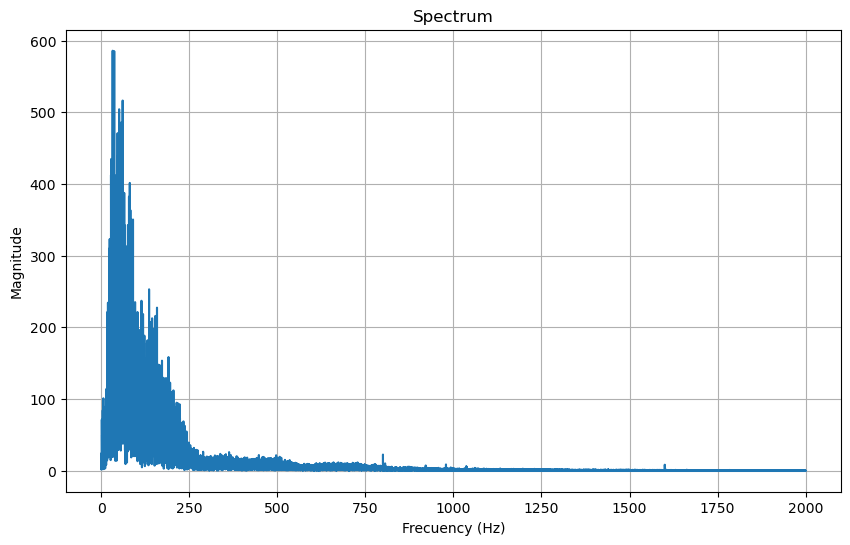

Dominant Frecuency: 32.69961977186311 Hz


In [170]:
#@title Extrasystole Sound Spectrum
frequencies, magnitudes, dominant_frequency = get_spectrum(rnd_extrastole, rnd_extrastole_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')

### Data Preprossecing


As it is evident, not all audio files have the same duration, which would pose the first problem. Additionally, it can also be observed that the sampling rate for audio segments in dataset A is 44100 Hz, while for dataset B it is 4000 Hz. Another important point to highlight is the class imbalance, where a higher number of data points can be noticed for the "murmur" and "normal" classes when considering all the data together.


#### Time Duration & Sample Rate


To solve the first problem, it is necessary to establish an equal time magnitude for all audio segments, which presents three cases:

- The duration is equal. No action would be taken on the audio segment.
- The duration is greater. The audio segment would need to be trimmed.
- The duration is shorter. It is necessary to fill in the missing time.

For the last two cases, the 'librosa.util.fix_length()' function can be used, as it is used to adjust the length of an audio signal based on the number of samples, rather than time. If the signal is shorter than the desired length, the function will fill the signal with repeated copies of the last value until it reaches the specified length. On the other hand, if the signal is longer than the desired length, the function will trim the signal to have the specified length.


In [ ]:
def fix_data():
    

### Noise

In [ ]:
for audio in FIR_filter(audio, sample_rate, cutoff_freq, num_taps)

In [169]:
#@title Fix Data
time_duration = 10 #seconds
sr = 22050
fix_normal_a_data = fix_audio_length(normal_a_data, time_duration, sr)
fix_murmur_a_data = fix_audio_length(murmur_a_data, time_duration, sr)
fix_extrahs_data = fix_audio_length(extrahs_data, time_duration, sr)
fix_artifact_data = fix_audio_length(artifact_data, time_duration, sr)
fix_normal_b_data = fix_audio_length(normal_b_data, time_duration, sr)
fix_murmur_b_data = fix_audio_length(murmur_b_data, time_duration, sr)
fix_extrastole_data = fix_audio_length(extrastole_data, time_duration, sr)

fix_normal_data = fix_normal_a_data + fix_normal_b_data
normal_labels = normal_a_labels + normal_b_labels
fix_murmur_data = fix_murmur_a_data + fix_murmur_b_data
murmur_labels = murmur_a_labels + murmur_b_labels

num_normal = len(fix_normal_data)
num_murmur = len(fix_murmur_data)
num_extrahs = len(fix_extrahs_data)
num_extrastole = len(fix_extrastole_data)
num_artifact = len(fix_artifact_data)

# View new dataset
num_classes = [num_normal, num_murmur, num_extrahs, num_extrastole, num_artifact]
tags = ['normal', 'murmur', 'extrahs', 'extrastole', 'artifact']

# Pie diagram
plt.pie(num_classes, labels=tags, autopct='%1.1f%%', startangle=90, colors=['red', 'green', 'blue', 'purple', 'orange'])
plt.axis('equal')
plt.title('New dataset distribution')
plt.show()

TypeError: 'int' object is not iterable

#### Class imbalance


### Filtro FIR (pasa bajas)

--- 

Imagina que tienes una señal de audio que deseas filtrar para eliminar el ruido de alta frecuencia no deseado. Aquí es donde entra en juego un filtro FIR. El filtro FIR actúa como un "pasa bajas" al atenuar las frecuencias altas y permitir que las frecuencias bajas pasen sin cambios significativos.

Un filtro FIR se compone de una secuencia de coeficientes, también llamada respuesta al impulso. Estos coeficientes definen la forma y las características del filtro. La longitud de esta secuencia determina la cantidad de muestras de entrada y salida que se tienen en cuenta en el proceso de filtrado.

El proceso de filtrado FIR se realiza multiplicando cada muestra de la señal de entrada con los coeficientes correspondientes del filtro y sumando los resultados ponderados. Aquí tienes un ejemplo sencillo para ilustrar este proceso:

Supongamos que tenemos una señal de audio con valores de amplitud [1, 2, 3, 4, 5] y un filtro FIR con coeficientes [0.2, 0.5, 0.3].

Primero, multiplicamos la primera muestra de la señal de entrada (1) por el primer coeficiente del filtro (0.2) y obtenemos 0.2.
Luego, multiplicamos la segunda muestra de la señal de entrada (2) por el segundo coeficiente del filtro (0.5) y obtenemos 1.0.
Continuamos este proceso para todas las muestras y coeficientes restantes.
Finalmente, sumamos todos los resultados ponderados: 0.2 + 1.0 + 0.9 + 1.2 + 1.5 = 4.8.
El resultado final (4.8) es la muestra filtrada correspondiente a la ubicación central de la señal de entrada. Repitiendo este proceso para cada muestra de entrada, obtenemos la señal filtrada completa.

La principal característica de un filtro FIR es que no introduce distorsión en la fase de la señal de entrada. Esto significa que las diferentes frecuencias de la señal se retrasan o adelantan de manera uniforme en el tiempo, lo cual es deseable en muchas aplicaciones de procesamiento de señales.

Cabe mencionar que los coeficientes del filtro FIR pueden ser diseñados de diversas maneras para lograr diferentes respuestas en frecuencia, como filtrado paso bajo, paso alto, paso de banda o rechazo de banda, según tus necesidades específicas.

Espero que este ejemplo y explicación detallada te ayuden a comprender mejor cómo funciona un filtro FIR. Si tienes más preguntas, no dudes en preguntar.

### Acelerar Audio

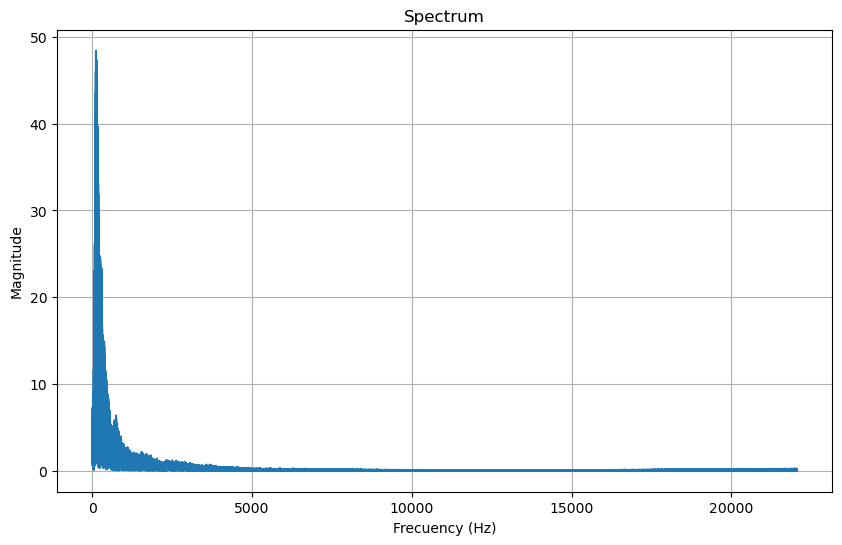

Dominant Frecuency: 117.20533538540464 Hz


In [111]:
rate=1.2
accelerated_normal = librosa.effects.time_stretch(rnd_normal_a, rate=rate)

frequencies, magnitudes, dominant_frequency = get_spectrum(accelerated_normal, rnd_normal_a_sr)

# Plot frecuency spectrum
plt.figure(figsize=(10, 6))
plt.plot(frequencies, magnitudes)
plt.xlabel('Frecuency (Hz)')
plt.ylabel('Magnitude')
plt.title('Spectrum')
plt.grid(True)
plt.show()

print('Dominant Frecuency:', dominant_frequency, 'Hz')